In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from time import time
import shutil
import sys
from IPython.display import display, Image

from sklearn.metrics import auc
from sklearn.metrics import roc_curve


from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.eager import context

from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import TensorBoard

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, Sequential 
from keras.optimizers import Adam,RMSprop,SGD


from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_data_format('channels_last')

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

print("Tensorflow is installed and is version: ",  tf.__version__)
print("Keras is installed and is version: ", tf.keras.__version__)

with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

Using TensorFlow backend.


Tensorflow is installed and is version:  1.11.0
Keras is installed and is version:  2.1.6-tf
[[22. 28.]
 [49. 64.]]


In [2]:
print(sys.version)
print(device_lib.list_local_devices())

3.6.5 |Anaconda custom (64-bit)| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 974331492263948398
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280557671
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17509718341104567201
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
dark2_cmap=ListedColormap(dark2_colors)

def set_mpl_params():
    rcParams['figure.figsize'] = (12, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

In [4]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()
        

def plot_accuracies_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'g-', label='Training acc', color = 'brown')
    plt.plot(epochs, val_acc, 'g-', label='Validation acc', color = 'orange')
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
 
    plt.plot(epochs, loss, 'g-', label='Training loss', color = 'brown')
    plt.plot(epochs, val_loss, 'g-', label='Validation loss', color = 'orange')
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [5]:
## Given a base directory it creates two directories and uses the truth.txt 
## file to split the files into these two directories
def organize_folders (base_dir):
    truth_file = os.path.join(base_dir,'truth.txt')
    portrait_dir = os.path.join(base_dir, 'portrait')
    landscape_dir = os.path.join(base_dir, 'landscape')

    # CREATE THE TWO FOLDERS IF THEY DONT EXIST ALREADY
    if not os.path.exists(portrait_dir):
             os.makedirs(portrait_dir)
    if not os.path.exists(landscape_dir):
             os.makedirs(landscape_dir)

    with open(truth_file) as f:
        for line in f:
            data = line.split()
            image_file = os.path.join(base_dir, data[0])
            image_type = data[1]
            if os.path.exists(image_file):
                if os.path.getsize(image_file) > 0:
                        if image_type == 'portrait':
                              shutil.move(image_file, portrait_dir)
                        if image_type == 'landscape':
                              shutil.move(image_file, landscape_dir)    
                print ("Moving:%s to %s"%(image_file,image_type))           
                
# SPECIFY THE THREE BASE DIRECTORIES
train_dir = './images64/train'
validation_dir = './images64/validation'
test_dir = './images64/test'

# ORGANISE EACH DIRECTORY INTO PORTRAIT AND LANDSCAPE DIRs
organize_folders(train_dir)
organize_folders(validation_dir)
organize_folders(test_dir)

# All images will be rescaled by 1./255
datagen = ImageDataGenerator(rescale=1./255)

# generator for the training data
train_generator = datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 64x64
        target_size=(64, 64),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# generator for the validation data
validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

# generator for the test data
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(64, 64),
        # NO shuffle for the test set to be able to track the file names
        shuffle = False,
        batch_size=32,  # this just makes sure it gets through memory
        class_mode='binary')


Found 16315 images belonging to 2 classes.
Found 8158 images belonging to 2 classes.
Found 7379 images belonging to 2 classes.


In [49]:
def create_dog_images_dirs (base_images, dir_split_list):
    
    # Check if a list of dogs where provided if not return
    if (len(dir_split_list)) == 0:
        return 
    
    # Create the basic directory paths for the three main dirs
    testval_dirs = os.path.join(os.path.dirname(base_images) ,'testval_dogs')
    train_d = os.path.join(testval_dirs,'train')
    val_d = os.path.join(testval_dirs,'validation')
    test_d = os.path.join(testval_dirs,'test')
                        
    # Remove the old directories.    
    if os.path.exists(testval_dirs):
             shutil.rmtree(testval_dirs)
            
    # Create new directories.            
    os.makedirs(testval_dirs)
    os.makedirs(train_d)
    os.makedirs(val_d)
    os.makedirs(test_d) 
    
    
    # Iterate through each dog 
    
    
    for dog in dir_split_list:

        # Get the dogs name
        name = dog['name']
    
        # Create dirs with the name of the dog
        dog_train_dst = os.path.join(train_d, name)
        dog_val_dst = os.path.join(val_d, name)
        dog_test_dst = os.path.join(test_d, name)
    
        os.makedirs(dog_train_dst)
        os.makedirs(dog_val_dst)
        os.makedirs(dog_test_dst)
    
        # Collect info about this dogs directory and calculate the split numbers
        path, dirs, files = os.walk(os.path.join(base_images, name)).__next__()
        file_count = len(files)    
        train_count = int(file_count * dog['train'])
        val_count = int(file_count * dog['val'])
        test_count = file_count - train_count - val_count

        # Copy the files
        for i, file in enumerate(files, start =1):
            if i <= train_count: 
                shutil.copy(os.path.join(path, file),os.path.join(dog_train_dst, file))
            if i <= val_count: 
                shutil.copy(os.path.join(path, file),os.path.join(dog_val_dst, file))
            if i <= test_count: 
                shutil.copy(os.path.join(path, file),os.path.join(dog_test_dst, file))  
    return train_d, val_d, test_d
  
dogs2 = [{'name': 'golden_retriever', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'curly-coated_retriever', 'train': 0.70, 'val': 0.15, 'test': 0.15}
        ]

dogs4 = [{'name': 'golden_retriever', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'curly-coated_retriever', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'Australian_terrier', 'train': 0.70, 'val': 0.15, 'test': 0.15},
        ]

dogs8 = [{'name': 'golden_retriever', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'curly-coated_retriever', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'Australian_terrier', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'Chihuahua', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'German_shepherd', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'Japanese_spaniel', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'Tibetan_mastiff', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'toy_poodle', 'train': 0.70, 'val': 0.15, 'test': 0.15}
        ]
 

train_dir, validation_dir, test_dir = create_dog_images_dirs ('./dog_images', dogs4)



# All images will be rescaled by 1./255
datagen = ImageDataGenerator(rescale=1./255)

# generator for the training data
train_generator = datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 64x64
        target_size=(64, 64),
        batch_size=3,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# generator for the validation data
validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=3,
        class_mode='binary')

# generator for the test data
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(64, 64),
        # NO shuffle for the test set to be able to track the file names
        shuffle = False,
        batch_size=3,  # this just makes sure it gets through memory
        class_mode='binary')
    
 

Found 347 images belonging to 3 classes.
Found 73 images belonging to 3 classes.
Found 77 images belonging to 3 classes.


In [50]:
# USE THE TRAIN DATA GENERATOR CREATED ABOVE TO GENERATE FIRST FIVE PORTRAITS AND LANDSCAPES
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break



K.clear_session()

#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
tensorboard = TrainValTensorBoard("logs/{}".format(time()), write_graph=True)

def simple_model():
    model = Sequential(name='SimpleModel')
    model.add(Conv2D(32, (2, 2), strides = (1, 1), padding='same',activation='relu',
                            input_shape=data_batch.shape[1:], name = 'conv1'))
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid', name='max_pool1'))
    model.add(Conv2D(64, (2, 2), strides = (1, 1), padding='same', activation='relu', name = 'conv2'))
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid', name='max_pool2'))
    model.add(Flatten())
    model.add(Dense(1024, kernel_initializer='glorot_uniform', activation='relu', name='fc1'))
    model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid', name='fc2'))
    
    sgd = SGD(lr = 0.05, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

cnn1_simple = simple_model()
cnn1_simple.summary()

# Fit model
history = cnn1_simple.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
    callbacks=[tensorboard])


data batch shape: (3, 64, 64, 3)
labels batch shape: (3,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        416       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              16778240  
_________________________________________________________________
fc2 (Dense)       

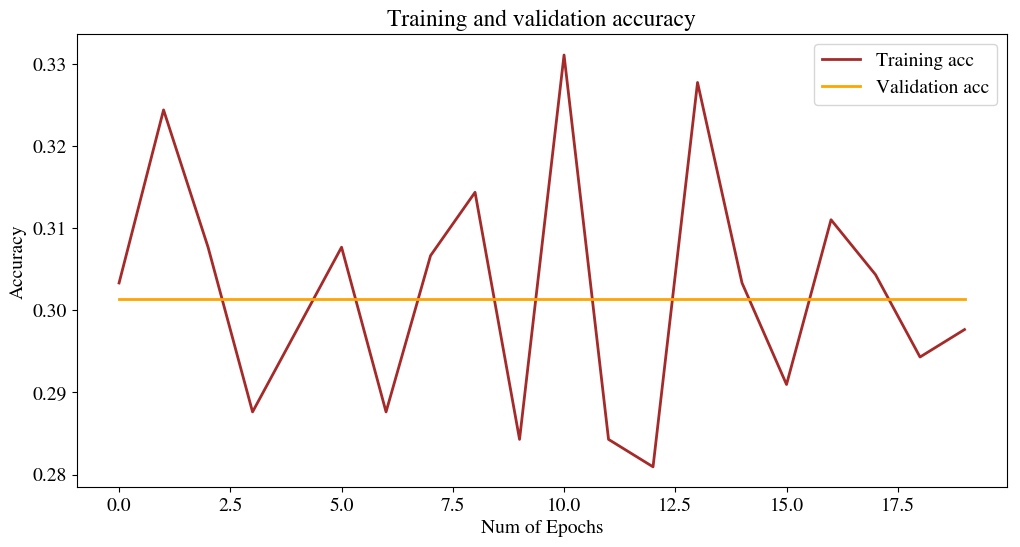

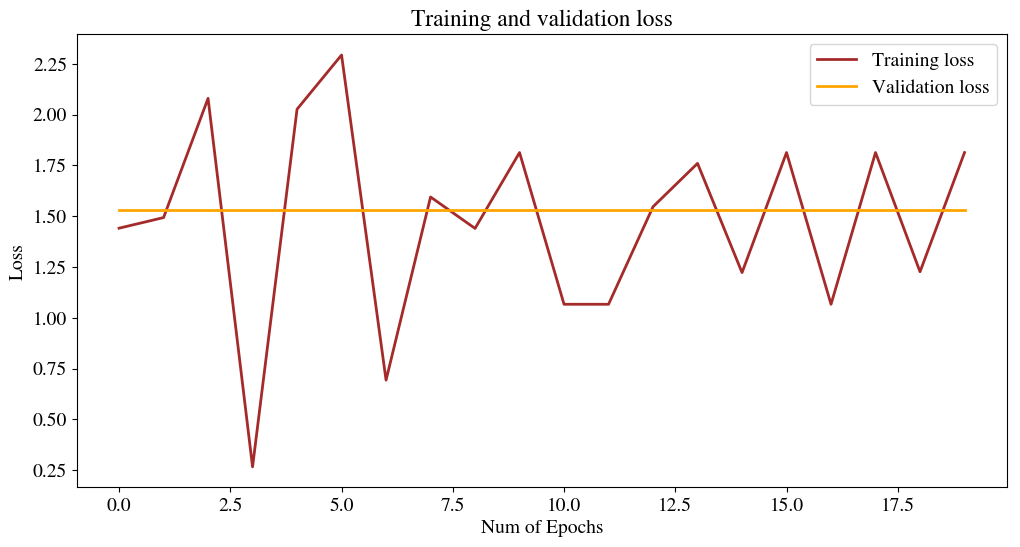

In [51]:
plot_accuracies_loss(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        896       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 128)       73856     
__________

100/100 [==============================] - 1s 15ms/step - loss: -1.5482 - acc: 0.4183 - val_loss: -1.5713 - val_acc: 0.4726
Epoch 43/60
100/100 [==============================] - 2s 15ms/step - loss: -1.7358 - acc: 0.4500 - val_loss: -0.8009 - val_acc: 0.5548
Epoch 44/60
100/100 [==============================] - 2s 15ms/step - loss: -2.0570 - acc: 0.4117 - val_loss: -1.3909 - val_acc: 0.4178
Epoch 45/60
100/100 [==============================] - 2s 15ms/step - loss: -1.9162 - acc: 0.4300 - val_loss: -0.8537 - val_acc: 0.3973
Epoch 46/60
100/100 [==============================] - 1s 15ms/step - loss: -2.3992 - acc: 0.4433 - val_loss: -0.2212 - val_acc: 0.3973
Epoch 47/60
100/100 [==============================] - 2s 15ms/step - loss: -2.3089 - acc: 0.4833 - val_loss: -1.0042 - val_acc: 0.5137
Epoch 48/60
100/100 [==============================] - 1s 15ms/step - loss: -2.4094 - acc: 0.4583 - val_loss: -0.0810 - val_acc: 0.5205
Epoch 49/60
100/100 [==============================] - 1s 15

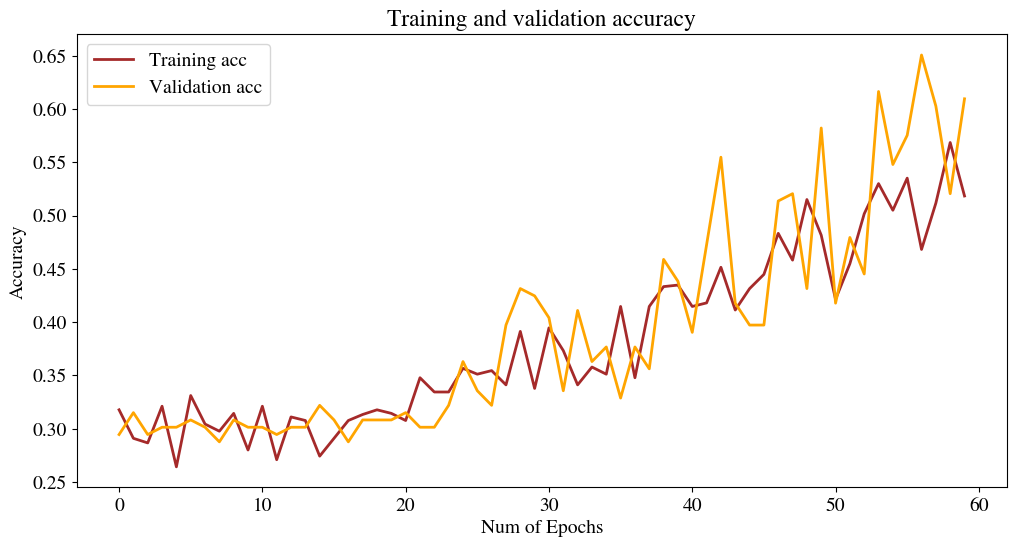

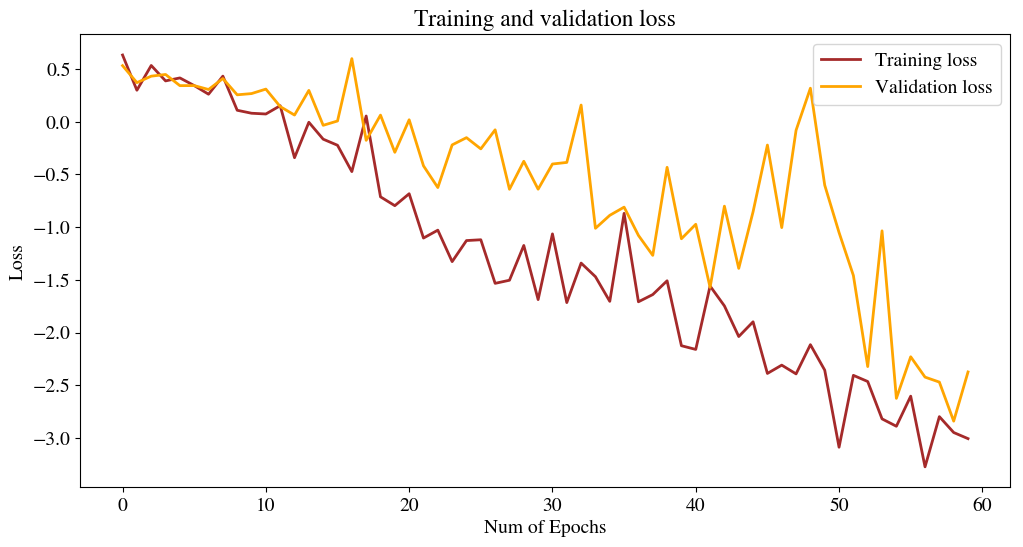

In [52]:
K.clear_session()

def reduce_overfit_model():

    model = Sequential(name='FiveLayerModel')
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                            input_shape=data_batch.shape[1:], name = 'conv1'))
    model.add(MaxPooling2D((2, 2), name='max_pool1'))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name = 'conv2'))
    model.add(MaxPooling2D((2, 2), name='max_pool2'))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = 'conv3'))
    model.add(MaxPooling2D((2, 2), name='max_pool3'))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = 'conv4'))
    model.add(MaxPooling2D((2, 2), name='max_pool4'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name = 'conv5'))
    model.add(Conv2D(512,(3, 3), padding='same', activation='relu', name = 'conv6'))
    model.add(MaxPooling2D((2, 2), name='max_pool5'))
    model.add(Flatten())
    model.add(Dense(512, kernel_initializer='glorot_uniform', activation='relu', name='fc1'))
    model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid', name='fc2'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])
    #model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])
    return model

cnn_reduce_overfit = reduce_overfit_model()
cnn_reduce_overfit .summary()

# Fit model
history_reduce_overfit = cnn_reduce_overfit .fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=60,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
    callbacks=[TrainValTensorBoard("logs/{}".format(time()), write_graph=True)])

plot_accuracies_loss(history_reduce_overfit)